In [1]:
%%capture
!pip install torchmetrics
!pip install torchinfo
!pip install seaborn
!pip install torchvision

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Preprocessing
import cv2
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.classification import MulticlassAccuracy
from torchvision.models import resnet50, ResNet50_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# typing
from typing import Dict, List

# Counter
from collections import Counter

# random
import random

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
IMAGE_PATH = Path("SB-FishDisease")

image_path_list_jpg = list(IMAGE_PATH.glob("*/*.jpg"))
image_path_list_jpeg = list(IMAGE_PATH.glob("*/*.jpeg"))
image_path_list_png = list(IMAGE_PATH.glob("*/*.png"))
image_path_list_JPG = list(IMAGE_PATH.glob("*/*.JPG"))
image_path_list_webp = list(IMAGE_PATH.glob("*/*.webp"))

TOTAL_IMAGE_PATH_LIST = image_path_list_jpg + image_path_list_jpeg + image_path_list_png\
                        + image_path_list_JPG + image_path_list_webp

print(f'Total Images = {len(TOTAL_IMAGE_PATH_LIST)}')

Total Images = 617


In [4]:
# Let's visualize how many classes we have.
classes = sorted(os.listdir(IMAGE_PATH))
classes

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

In [5]:
# Let's see how many images per class we have.
class_count = []
for i in TOTAL_IMAGE_PATH_LIST:
    class_count.append(i.parent.stem)

Counter(class_count)

Counter({'Healthy Fish': 246,
         'Bacterial diseases - Aeromoniasis': 77,
         'Bacterial Red disease': 68,
         'Fungal diseases Saprolegniasis': 65,
         'Bacterial gill disease': 58,
         'Viral diseases White tail disease': 55,
         'Parasitic diseases': 48})

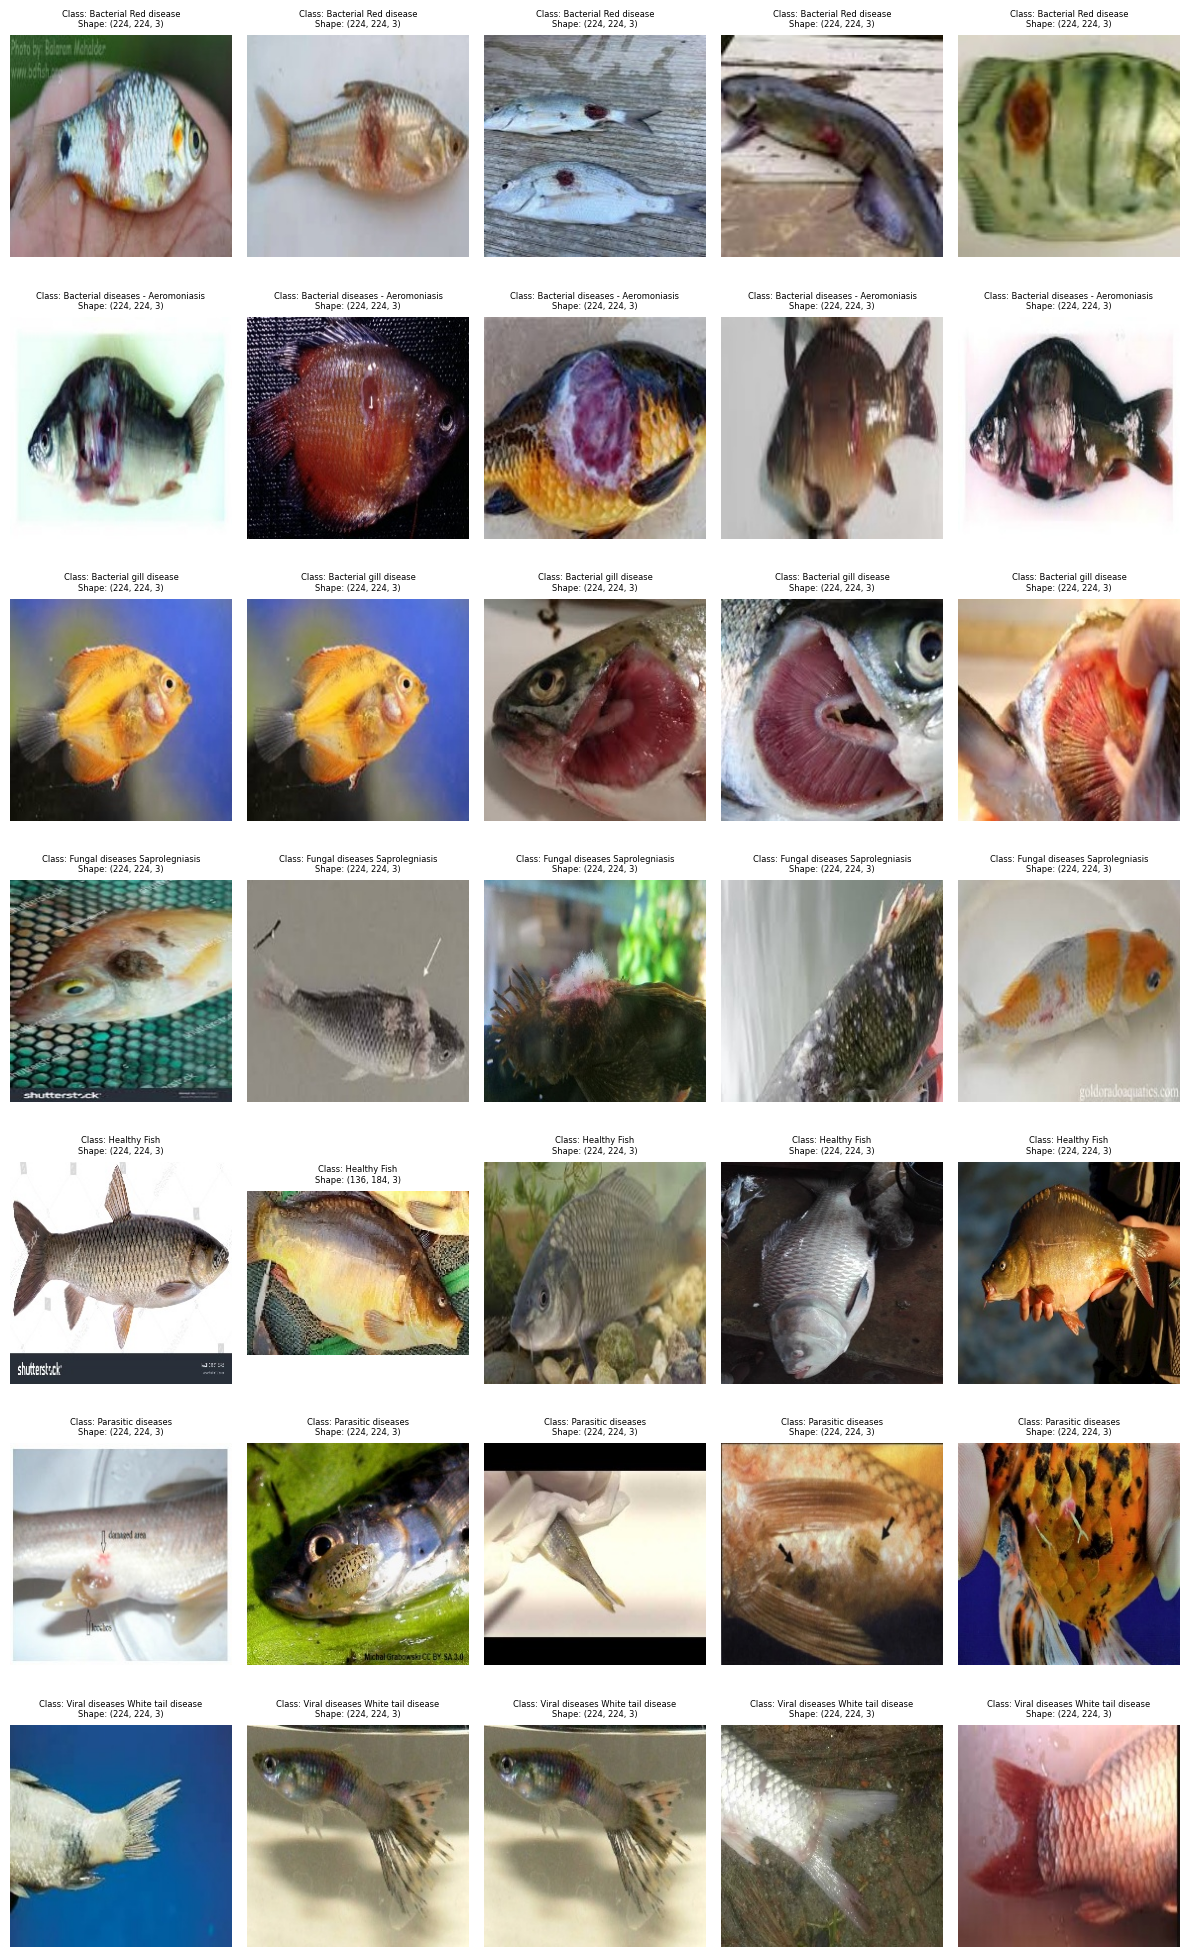

In [6]:
# Let's visualize 5 images for each class.

fig,ax = plt.subplots(nrows = 7, ncols = 5, figsize = (12,20))
p = 0
for c in classes:
    
    a = random.choices(list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg")), k = 5)
    
    for i,j in enumerate(a):
        img_BGR = cv2.imread(str(j))
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_RGB)
        ax[p,i].set_title(f'Class: {j.parent.stem}\nShape: {img_RGB.shape}', fontsize = 6)
        ax[p,i].axis('off')
    p += 1
        
fig.tight_layout()
fig.show()

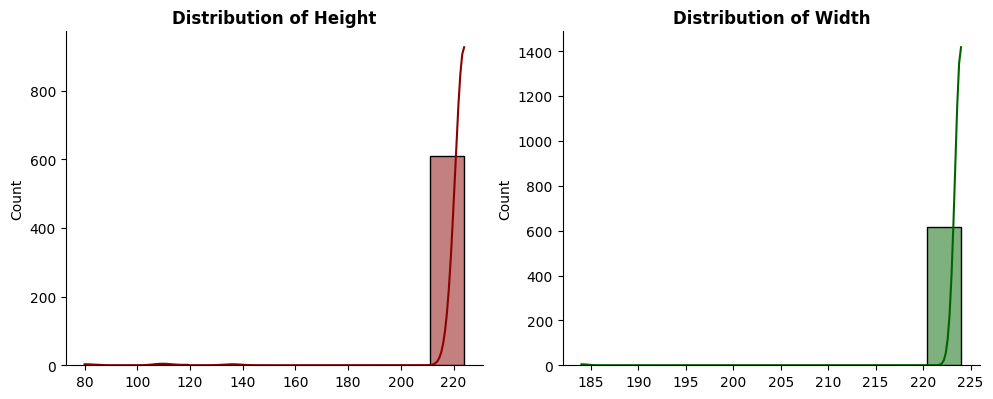

In [7]:
seq_height = []
seq_width = []

for i in TOTAL_IMAGE_PATH_LIST:
    img_BGR = cv2.imread(str(i))
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    seq_height.append(img_RGB.shape[0])
    seq_width.append(img_RGB.shape[1])
    
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4.1))
ax = ax.flat

sns.histplot(seq_height, kde = True, color = 'darkred', ax = ax[0])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Distribution of Height', fontweight = 'bold', color = 'black')

sns.histplot(seq_width, kde = True, color = 'darkgreen', ax = ax[1])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Distribution of Width', fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

In [8]:
df_height_width = pd.DataFrame({'height':seq_height, 'width':seq_width})

df_height_width.describe().T

,count,mean,std,min,25%,50%,75%,max
height,617.0,222.692058,12.426504,80.0,224.0,224.0,224.0,224.0
width,617.0,223.870340,2.275515,184.0,224.0,224.0,224.0,224.0


In [9]:
# Let's create our pd.DataFrame to store the path of the images and their respective label.
img_path_and_label = {'img_path':[], 
                      'label':[]}

for img_pth in TOTAL_IMAGE_PATH_LIST:
    img_path_and_label['img_path'].append(img_pth)
    img_path_and_label['label'].append(img_pth.parent.stem)
    
df_path_and_label = pd.DataFrame(img_path_and_label)
df_path_and_label.head()

,img_path,label
0,SB-FishDisease\Bacterial diseases - Aeromonias...,Bacterial diseases - Aeromoniasis
1,SB-FishDisease\Bacterial diseases - Aeromonias...,Bacterial diseases - Aeromoniasis
2,SB-FishDisease\Bacterial diseases - Aeromonias...,Bacterial diseases - Aeromoniasis
3,SB-FishDisease\Bacterial diseases - Aeromonias...,Bacterial diseases - Aeromoniasis
4,SB-FishDisease\Bacterial diseases - Aeromonias...,Bacterial diseases - Aeromoniasis


In [10]:
# Now we are going to separate the paths of the images and their respective label.
X = df_path_and_label.drop('label', axis = 1)
y = df_path_and_label['label']

# Then, let's split into training and test set.
# But first we define the random seed for reproducibility.
SEED = 42

X_train, X_test, y_train, y_test = tts(X,y, test_size = 0.2, random_state = SEED, stratify = y)

In [11]:
print('Total Images of training set:')
print(Counter(y_train))
print('')

print('Total Images of test set:')
print(Counter(y_test))

Total Images of training set:
Counter({'Healthy Fish': 197, 'Bacterial diseases - Aeromoniasis': 62, 'Bacterial Red disease': 54, 'Fungal diseases Saprolegniasis': 52, 'Bacterial gill disease': 46, 'Viral diseases White tail disease': 44, 'Parasitic diseases': 38})

Total Images of test set:
Counter({'Healthy Fish': 49, 'Bacterial diseases - Aeromoniasis': 15, 'Bacterial Red disease': 14, 'Fungal diseases Saprolegniasis': 13, 'Bacterial gill disease': 12, 'Viral diseases White tail disease': 11, 'Parasitic diseases': 10})


In [12]:
# Now we have to convert our labels to number, where:
# Bacterial Red disease = 0
# Bacterial diseases - Aeromoniasis = 1
# Bacterial gill disease = 2
# Fungal diseases Saprolegniasis = 3
# Healthy Fish = 4
# Parasitic diseases = 5
# Viral diseases White tail disease = 6

label_map = dict(zip(classes, range(0,7)))

y_train_array = np.array(y_train.map(label_map))
y_train_torch = torch.from_numpy(y_train_array)

y_test_array = np.array(y_test.map(label_map))
y_test_torch = torch.from_numpy(y_test_array)
y_test_torch

tensor([4, 4, 4, 6, 4, 0, 4, 3, 4, 1, 4, 4, 0, 4, 0, 3, 1, 2, 4, 5, 4, 4, 0, 3,
        4, 4, 2, 4, 6, 2, 4, 4, 4, 1, 4, 1, 4, 2, 3, 5, 4, 4, 1, 3, 6, 1, 3, 2,
        6, 1, 0, 0, 5, 4, 4, 1, 4, 2, 4, 6, 4, 4, 3, 0, 4, 3, 5, 4, 1, 4, 4, 4,
        4, 4, 4, 3, 6, 1, 5, 0, 5, 5, 2, 2, 4, 1, 3, 0, 2, 5, 2, 0, 4, 4, 6, 4,
        4, 4, 4, 4, 0, 5, 0, 3, 4, 3, 1, 4, 0, 2, 5, 4, 0, 1, 4, 6, 3, 1, 6, 2,
        6, 6, 4, 1])

In [13]:
# We define the transformations for our data set.
weights = ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [14]:
# We apply the transformations to our data sets.

images_train = [None] * len(X_train)

for i, (_,img_path_train) in enumerate(X_train.iterrows()):
    img_train = Image.open(img_path_train[0]).convert('RGB')
    images_train[i] = auto_transforms(img_train)
    
images_test = [None] * len(X_test)

for i, (_, img_path_test) in enumerate(X_test.iterrows()):
    img_test = Image.open(img_path_test[0]).convert('RGB')
    images_test[i] = auto_transforms(img_test)

In [15]:
# We will then convert our lists of tensors into a single tensor.
X_train_torch = torch.stack(images_train)
X_test_torch = torch.stack(images_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

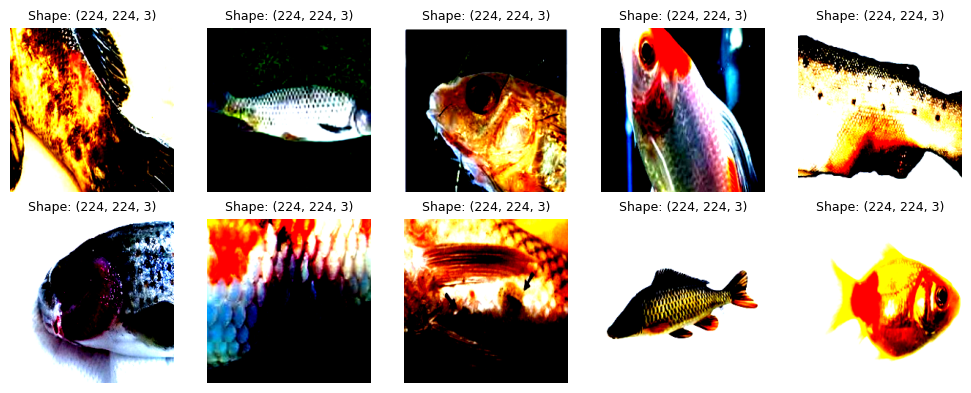

In [16]:
# Let's visualize some randomly selected transformed images.
indices = torch.randperm(10).numpy()

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,4))
ax = ax.flat

for i,j in enumerate(indices):
    IMG = X_train_torch[j].permute(1,2,0).numpy()
    ax[i].imshow(IMG)
    ax[i].set_title(f'Shape: {IMG.shape}', fontsize = 9)
    ax[i].axis('off')
    
fig.tight_layout()
fig.show()

In [17]:
# First of all, we convert to Dataset but for this we have to create a Dataset class.
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx]
        
        return x,y

In [18]:
# Now we convert to Dataset.
train_dataset = CustomDataset(X_train_torch, y_train_torch)
test_dataset = CustomDataset(X_test_torch, y_test_torch)

In [19]:
# Then we convert to DataLoader.
BATCH_SIZE = 4
NUM_WORKERS = 2

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS,
                             )

test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                             num_workers = NUM_WORKERS,
                            )

In [20]:
# Let's visualize a batch.
images_batch, labels_batch = next(iter(train_dataloader))

images_batch.shape, labels_batch.shape

RuntimeError: DataLoader worker (pid(s) 10584, 9612) exited unexpectedly

In [21]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'